In [1]:
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [50]:
sns.set(style='whitegrid')

In [11]:
mean_xyz = pd.read_csv('no_over_3mm_mean/roi_MeanXYZ', header=None, names= ['x','y','z'], sep='\t')
mean_xyz.head()

,x,y,z
0,4.69,-77.80,27.27
1,5.08,-92.06,-13.39
2,24.73,-9.87,61.96
3,-0.16,35.16,-16.18
4,-19.91,-63.44,62.44


In [34]:
range(10)[:3]

[0, 1, 2]

In [76]:
def activity_for(file):
    answer = []
    with open(file) as f:
        for line in f.readlines():
            values = line.split('\t')
            answer.append([float(x) for x in values[:3]] + [len(values) - 3])
    return pd.DataFrame(answer, columns=['x', 'y', 'z', 'total'])

In [91]:
def inputs_and_regions_for(energy_name):
    inputData = pd.read_csv('SampleLogs/{}_Input.csv'.format(energy_name), index_col='time', \
                            names= ['time', 'source', 'destination', 'inhibitor'])
    regions = pd.read_csv('SampleLogs/{}_Region.csv'.format(energy_name), index_col='neuron', \
                          names=['neuron', 'region'])
    lowerLimit = pd.to_datetime(5, unit='s')
    inputData.index = pd.to_datetime(inputData.index, unit='ms')
    inputData = inputData[lowerLimit:]
    inputs_and_regions = inputData.join(regions, \
                                        on='source').join(regions, \
                                        on= 'destination', lsuffix='_src', rsuffix='_dst')
    inputs_and_regions['efective_input'] = 1*(1-inputs_and_regions.inhibitor) -1*inputs_and_regions.inhibitor
    answer = inputs_and_regions.groupby([inputs_and_regions.region_src  == inputs_and_regions.region_dst, 'region_src']).\
            efective_input.count().unstack().T
    answer['total'] = answer.sum(axis=1)
    answer = answer.rename(columns={True: 'within_regions', False:'between_regions'})
    return answer

In [77]:
gluco = activity_for('3_data/reno_over_3mm_meaninvitationtocollaborate/3mm_mean-GLUCO_XYZspikeTrain.txt')

In [78]:
hypo = activity_for('3_data/reno_over_3mm_meaninvitationtocollaborate/3mm_mean-hypo_XYZspikeTrain.txt')

In [79]:
keto = activity_for('3_data/reno_over_3mm_meaninvitationtocollaborate/3mm_mean-KETO_XYZspikeTrain.txt')

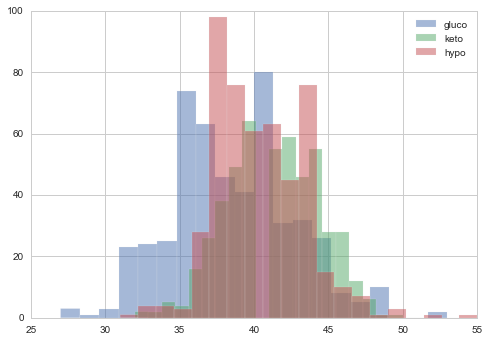

In [80]:
gluco.total.hist(alpha=0.5, bins=20, label='gluco')
keto.total.hist(alpha=0.5, bins=20, label='keto')
hypo.total.hist(alpha=0.5, bins=20, label='hypo')
plt.legend()

In [81]:
region_location = pd.read_csv('../static/models/regions.obj', header=None, sep=' ')
region_location.index = range(1, len(region_location)+1)
region_location = region_location.drop(0, axis=1)
region_location.columns = ['x', 'y', 'z']

In [82]:
region_location.shape

(188, 3)

In [83]:
min_sqrt = lambda serie: ((serie.x-region_location.x)**2 + (serie.y-region_location.y)**2 \
                          + (serie.z-region_location.z)**2).argmin()

In [84]:
gluco['region'] = gluco.apply(min_sqrt, axis=1)
hypo['region'] = hypo.apply(min_sqrt, axis=1)
keto['region'] = keto.apply(min_sqrt, axis=1)

In [85]:
gluco.index = gluco.region
hypo.index = hypo.region
keto.index = keto.region

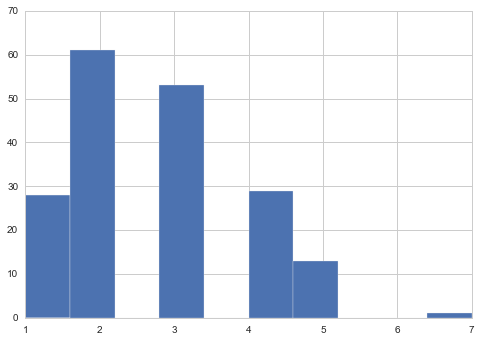

In [86]:
gluco.region.value_counts().hist()

In [87]:
region_names = pd.read_csv('1013090_DTI_region_names_full_file.txt')
region_names.head()

,Brain-Stem
0,Right Planum Polare
1,Left Temporal Pole
2,Right Frontal Pole
3,Right Temporal Fusiform anterior
4,Left Frontal Pole


In [88]:
region_names.index = region_names.index+1

In [92]:
medium = inputs_and_regions_for('MediumConst')
low  = inputs_and_regions_for('LowConst')
high  = inputs_and_regions_for('HighConst')

In [135]:
mapping = {k:v.groupby('region').aggregate(np.sum) for k, v in \
         {'gluco': gluco, 'hypo': hypo, 'keto' : keto}.iteritems()}
mapping.update({'medium': medium, 'low': low, 'high': high})
df = pd.DataFrame.from_dict({k:pd.Series(v.sort_values('total', ascending=False).index) for k,v in mapping.iteritems()})

In [136]:
df = df.fillna(0)

In [138]:
df.corr(method='kendall')

,gluco,high,hypo,keto,low,medium
gluco,1.000000,-0.093022,0.148450,0.089616,-0.090974,0.112366
high,-0.093022,1.000000,-0.079709,0.045345,0.025942,0.033223
hypo,0.148450,-0.079709,1.000000,0.106117,-0.066964,0.027139
keto,0.089616,0.045345,0.106117,1.000000,-0.011094,0.009729
low,-0.090974,0.025942,-0.066964,-0.011094,1.000000,-0.013767
medium,0.112366,0.033223,0.027139,0.009729,-0.013767,1.000000


In [169]:
def sorting_and_naming(df):
    values =  df.join(region_names).sort_values('total', ascending=False)['Brain-Stem'].values
    return pd.Series(values)

In [162]:
df = pd.DataFrame.from_dict({k: sorting_and_naming(v)\
                             for k,v in mapping.iteritems()})

In [174]:
df.head()

,gluco,high,hypo,keto,low,medium
0,Left Postcentral,Left Cingulate anterior,Left Postcentral,Left Postcentral,Left Paracingulate,Right Paracingulate
1,Right V,Right Precentral,Left Angular,Right Temporal Pole,Left Lateral Occipital superior,Left Temporal Fusiform posterior
2,Left Angular,Right Crus I,Right V,Left Angular,Left Frontal Pole,Right Postcentral
3,Right Postcentral,Left Temporal Occipital Fusiform,Right Temporal Pole,Right Lateral Occipital superior,Left Postcentral,Left Supramarginal anterior
4,Right Temporal Pole,Right Temporal Pole,Right Postcentral,Right Superior Temporal posterior,Right Central Opercular,Left Cingulate posterior


In [177]:
(df.gluco == df.high).mean()

0.026595744680851064

In [178]:
(df.gluco == df.hypo).mean()

0.074468085106382975

In [179]:
(df.gluco == df.keto).mean()

0.042553191489361701

In [180]:
(df.gluco == df.medium).mean()

0.021276595744680851

In [181]:
(df.high == df.low).mean()

0.010638297872340425

In [182]:
(df.high == df.medium).mean()

0.037234042553191488

In [183]:
(df.high == df.hypo).mean()

0.0053191489361702126

In [184]:
(df.medium == df.low).mean()

0.0053191489361702126

In [201]:
index = mapping['gluco'].index

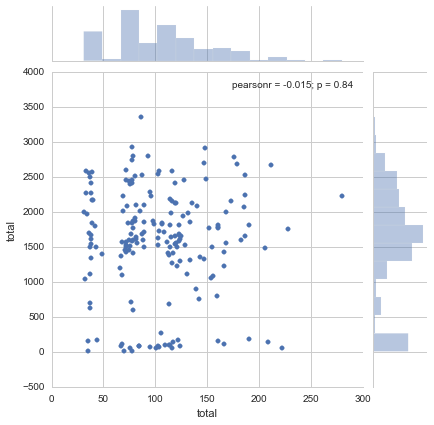

In [205]:
sns.jointplot(mapping['gluco'].ix[index].total, mapping['low'].ix[index].total)

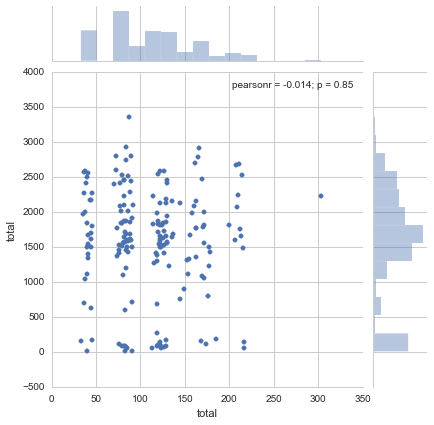

In [206]:
sns.jointplot(mapping['keto'].ix[index].total, mapping['low'].ix[index].total)

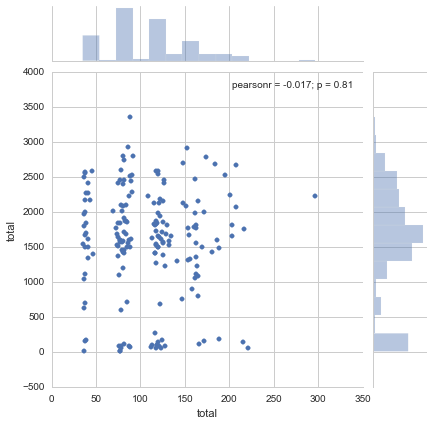

In [207]:
sns.jointplot(mapping['hypo'].ix[index].total, mapping['low'].ix[index].total)

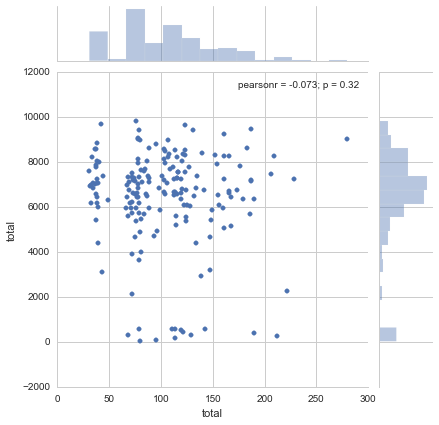

In [209]:
sns.jointplot(mapping['gluco'].ix[index].total, mapping['high'].ix[index].total)